In [1]:
import importlib
import time

import wumpus
import aufgabe2
import aufgabe2_friend
import agents

In [31]:
def visualize_episode(agent, env):
    agent.new_episode()

    terminated = False
    percept = env.reset()
    total_reward = 0
    reward = 0
    while not terminated:
        action = agent.get_action(percept, reward)
        display(env.render(), clear=True)
        print(action)
        time.sleep(0.5)
        percept, reward, terminated, info = env.step(action)
        total_reward += reward
    print(f"episode finished with reward {total_reward}")



In [44]:
importlib.reload(aufgabe2)
size = (4, 4)
env = wumpus.Wumpus(seed=2025, size=size)

# agent = agents.AgentV2(size=size)
# agent = aufgabe2.Agent(size=size)
agent = aufgabe2_friend.Agent(size=size)

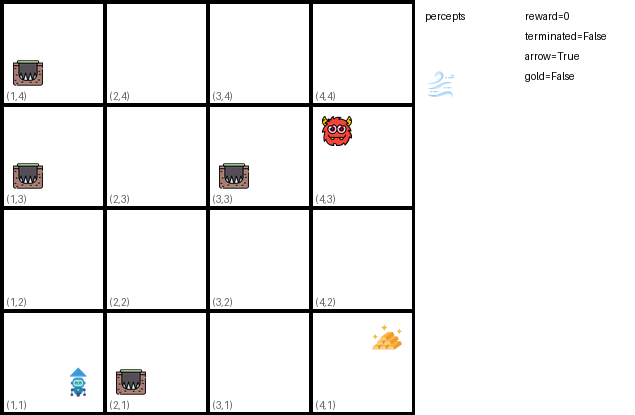

5
episode finished with reward -1


In [49]:
visualize_episode(agent, env)

In [61]:
env.reset()

array([0, 1, 0, 0, 0])

In [94]:
import aufgabe2_mike
importlib.reload(aufgabe2_mike)

agent = aufgabe2_mike.Agent(size=size)

In [95]:
agent.new_episode()
agent._get_observation()

array([ 0,  0,  0,  1,  0,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1])

In [90]:
np.clip(-100, 0, 3)

0

In [97]:
import importlib
import stable_baselines3
import aufgabe2_mike
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.env_util import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
import torch

env_fn_easy = lambda: Monitor(aufgabe2_mike.WumpusEnv(seed=None, p_pit=0., Tmax=100))
env_fn_hard = lambda: Monitor(aufgabe2_mike.WumpusEnv(seed=None, p_pit=0.2, Tmax=50))

In [100]:
importlib.reload(aufgabe2_mike)
env_fn = lambda: aufgabe2_mike.WumpusEnv(seed=None)
# vec_env = make_vec_env(env_fn, n_envs=64)
vec_env = make_vec_env(env_fn_easy, n_envs=64)

In [21]:
policy_kwargs = {
    "net_arch": [64, 64],
    "activation_fn": torch.nn.Tanh,
    "optimizer_class": torch.optim.AdamW,
}
agent = stable_baselines3.PPO(
    "MlpPolicy",
    vec_env,
    learning_rate=1e-3,
    batch_size=512,
    ent_coef=0.03,
    policy_kwargs=policy_kwargs,
    verbose=1
)

Using cpu device


In [ ]:
torch.set_num_threads(2)
1_000_000
agent.learn(total_timesteps=6_000_000, log_interval=1)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.65     |
|    ep_rew_mean     | 27.7     |
| time/              |          |
|    fps             | 7384     |
|    iterations      | 1        |
|    time_elapsed    | 17       |
|    total_timesteps | 131072   |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.6        |
|    ep_rew_mean          | 18.2       |
| time/                   |            |
|    fps                  | 4812       |
|    iterations           | 2          |
|    time_elapsed         | 54         |
|    total_timesteps      | 262144     |
| train/                  |            |
|    approx_kl            | 0.01525862 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.21      |
|    explained_variance   | 0.969      |
|    learning_rate        | 0.001      |
|   

In [108]:
# agent.save("ppo_agent")
agent = stable_baselines3.PPO.load("ppo_agent", env=vec_env)

In [109]:
mean, std = evaluate_policy(agent, vec_env, n_eval_episodes=5_000)
print(f"{mean:.2f} ± {std:.2f}")

59.74 ± 238.72


In [71]:
1000 / 16

62.5

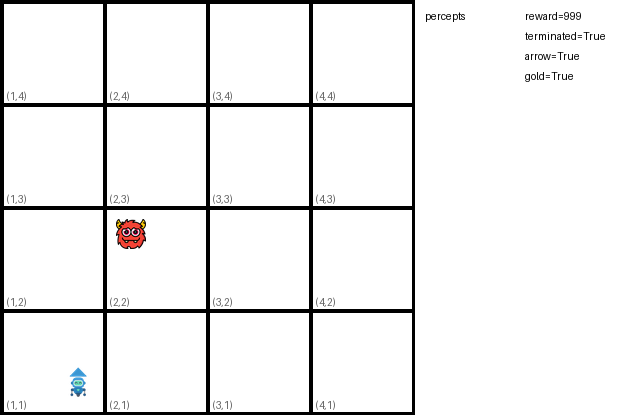

5
episode finished with reward 998


In [106]:
def render_one_episode(agent, env):
    import time
    terminated = False
    observation, _ = env.reset()
    reward_total = 0
    while not terminated:
        action, _ = agent.predict(observation, deterministic=False)
        observation, reward, terminated, _, _ = env.step(action)
        display(env.render(), clear=True)
        print(action)
        reward_total += reward
        time.sleep(0.5)

    print(f"episode finished with reward {reward_total}")


# 6
# env = aufgabe2_mike.WumpusEnv(seed=6)
env = env_fn_easy()
render_one_episode(agent, env)